In [ ]:
# Load necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
from sklearn.cluster import KMeans
import yfinance as yf

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Numpy Version: 1.19.4
# Pandas Version: 1.2.4
# Scipy Version: 1.5.4
# Plotly Version: 5.2.1
# Matplotlib Version: 3.3.4
# Seaborn Version: 0.11.1
# yfinance Version: 0.1.64
# Sklearn Version: 0.23.2

In [ ]:
start = '2007-01-01'
end = '2023-02-01'

In [ ]:
data = pd.read_csv('NiftyHistoricalData.csv')
# data = pd.read_csv('NiftyHistoricalData.csv', index_col=0)
# data = yf.download('GME', start = start, end = end)

In [ ]:
#data = data[data['Date'] > '2013-12-31']

In [ ]:
# Preparing data for all time high value & pullback computation
data = round(data, 2)
data['all-time-high'] = data['Close'].expanding().max()
data['all-time-high-date'] = np.where(data['all-time-high'] == data['Close'], data['Date'], np.NaN)
data['all-time-high-date'] = data['all-time-high-date'].fillna(method='ffill')
data['all-time-next-high'] = np.where(data['all-time-high'].diff(), data['Close'], np.NaN)
data['all-time-next-high'] = data['all-time-next-high'].fillna(method='ffill')
data['all-time-next-high-date'] = np.where(data['all-time-high'].diff(), data['Date'], np.NaN)
data['all-time-next-high-date'] = data['all-time-next-high-date'].fillna(method='bfill')
data['pullback'] = 1 - data['Close'] / data['all-time-high']

In [ ]:
# Function to compute the logic of Dip Trip
def get_signal(data):
    '''
    Logic for Dip Trip Strategy
    '''
    pullback = data['pullback']
    
    if pullback >= 0.4:
        return '>40% dd'
    elif pullback >= 0.2:
        return '>20% dd'
    elif pullback >= 0.1:
        return '>10% dd'
    else: 
        return '< 10% dd'

def compute_possible_trades(signal_df, unique_logic):
    '''
    Filter possible trades
    - Remove duplicate trades
    - For one logic, only one trade at a time 
    '''
    trade_start = []
    trade_end = []
    for i in unique_logic:
        print(i)
        temp_df = signal_df[signal_df['logic'] == i]
        try:
            first_trade_start = temp_df['Date'].values[0]
            first_trade_end = temp_df['all-time-next-high-date'].values[0]
            print(first_trade_start, first_trade_end)

            trade_start.append(first_trade_start)
            trade_end.append(first_trade_end)
            for j in range(temp_df.shape[0]):
                try:
                    start_date = temp_df[temp_df['Date'] > 
                                         trade_end[-1]]['Date'].values[0]
                    end_date = temp_df[temp_df['Date'] > 
                                       trade_end[-1]]['all-time-next-high-date'].values[0]
                    if start_date != end_date:
                        trade_start.append(start_date)
                        trade_end.append(end_date)
                except:
                    pass
        except:
            pass
    return trade_start, trade_end

In [ ]:
#### Dip trip Strategy 
data_dip = data.copy()
data_dip['logic'] = data_dip.apply(get_signal, axis=1)

# Allowed signals
logic_dip = ['>10% dd', '>20% dd', '>40% dd']

data_dip['signal'] = np.where(data_dip['logic'].isin(logic_dip), 'buy', np.NaN)
data_dip['status'] = np.where(data_dip['signal'] == 'buy', 'open', 'close')

# Removing intital observations, to make it consistent with the Regime Shift Strategy
# Since we are considering the rolling values of mean and std deviation of returns
data_dip = data_dip[data_dip.index > 249]

# Filter possible trades
trade_start_dip, trade_end_dip = compute_possible_trades(data_dip, unique_logic=logic_dip)
data_dip.loc[~data_dip['Date'].isin(trade_start_dip), 'status'] = 'close'

# Filter the trades and compute returns for each trade
result_dip = data_dip[data_dip['status'] == 'open'].reset_index(drop=True)
result_dip['return'] =  round((result_dip['all-time-next-high']/result_dip['Close'])-1,4)*100

>10% dd
2009-09-30 2010-11-09
>20% dd
2008-09-18 2010-11-09
>40% dd
2008-10-06 2010-11-09


In [ ]:
### Coiled Spring Scenario
data_coiled_spring = data.copy()

# Pivot Low is the dummy variable, created to identify the low pivot points in the OHLC data
# Pivot High is the dummy variable, created to identify the high pivot points in the OHLC data
data_coiled_spring['pivot-low'] = 0
data_coiled_spring['pivot-high'] = 0
# How many backward and forward candles to consider for identifying the low and high pivot points
num_back_candles = 2
num_fwd_candles = 2
# How many candles to consider for identifying the break out or break down
back_candles = 250

# Logic to find out the Low and high pivot points
for i in range(len(data_coiled_spring)):
    cond_check_low = list(data_coiled_spring.Low.iloc[i] < 
                          data_coiled_spring.Low.iloc[i-num_back_candles:i+num_fwd_candles+1,])
    cond_check_high = list(data_coiled_spring.High.iloc[i] > 
                           data_coiled_spring.High.iloc[i-num_back_candles:i+num_fwd_candles+1,])

    true_cond_low = dict(zip(*np.unique(cond_check_low, return_counts=True)))
    if (true_cond_low.get(False) == 1):
        data_coiled_spring['pivot-low'].iloc[i] = 1
        data_coiled_spring['pivot-high'].iloc[i] = 0
    
    true_cond_high = dict(zip(*np.unique(cond_check_high, return_counts=True)))        
    if (true_cond_high.get(False) == 1):
        data_coiled_spring['pivot-low'].iloc[i] = 0
        data_coiled_spring['pivot-high'].iloc[i] = 1

# Pivot poistion tells us about the high and low pivot points in the price candlestick chart
data_coiled_spring['pivot-position'] = np.where(data_coiled_spring['pivot-low']==1, data_coiled_spring['Low']-1e-3, 
                                  np.where(data_coiled_spring['pivot-high']==1, data_coiled_spring['High']+1e-3, np.NaN))

data_coiled_spring['pivot-position'] = data_coiled_spring['pivot-position'].fillna(method='ffill').fillna(method='bfill')
data_coiled_spring['pivot-logic'] = np.where(data_coiled_spring['Close'] < 
                                        data_coiled_spring['pivot-position'].rolling(window=back_candles).min(), 'break_down', 'break_out')

# Allowed signals
logic_coiled_spring = ['break_down']

data_coiled_spring['logic'] = data_coiled_spring['pivot-logic'].copy()

# Only break signals are allowed
data_coiled_spring['signal'] = np.where((data_coiled_spring['logic'].isin(logic_coiled_spring)), 'buy', np.NaN)
data_coiled_spring['status'] = np.where(data_coiled_spring['signal'] == 'buy', 'open', 'close')

# Filter possible trades
trade_start_coiled_spring, trade_end_coiled_spring = compute_possible_trades(data_coiled_spring, 
                                                                             unique_logic=logic_coiled_spring)
data_coiled_spring.loc[~data_coiled_spring['Date'].isin(trade_start_coiled_spring), 'status'] = 'close'

# Filter the trades and compute returns for each trade
result_coiled_spring = data_coiled_spring[data_coiled_spring['status'] == 'open'].reset_index(drop=True)
result_coiled_spring['return'] =  round((result_coiled_spring['all-time-next-high']/result_coiled_spring['Close'])-1,4)*100

break_down
2008-10-06 2010-11-09


In [ ]:
### Regime Shift Modeling with high std deviation scenario 
data_regime = data.copy()

# Computing mean and std deviation of returns, 
# based on which Kmeans cluster will be used to identify the regime
data_regime['mean-return'] = data_regime['Close'].pct_change().rolling(250).mean()
data_regime['std-return'] = data_regime['Close'].pct_change().rolling(250).std()
data_regime = data_regime.dropna()

# Split the dataset to avoid any overfitting 
split = 0.60
train = data_regime.iloc[:int(data_regime.shape[0]*split),:].dropna()
test = data_regime.iloc[int(data_regime.shape[0]*split):,:]

# Train the KMeans with 4 clusters
km = KMeans(n_clusters=4, random_state=123).fit(train[['mean-return', 'std-return']])

# Identify the clusters
data_regime.loc[:,'cluster'] = km.predict(data_regime[['mean-return', 'std-return']])
data_regime['logic'] = data_regime['cluster'].apply(lambda x: 'cluster_'+str(x))

# Allowed signals
logic_regime = ['cluster_1', 'cluster_3']

# Only high volatile regimes are considered to buy, when others are getting panic
data_regime['signal'] = np.where(data_regime['logic'].isin(logic_regime), 'buy', np.NaN)
data_regime['status'] = np.where(data_regime['signal'] == 'buy', 'open', 'close')

# Filter possible trades
trade_start_regime, trade_end_regime = compute_possible_trades(data_regime, unique_logic=logic_regime)
data_regime.loc[~data_regime['Date'].isin(trade_start_regime), 'status'] = 'close'

# Filter the trades and compute returns for each trade
result_regime = data_regime[data_regime['status'] == 'open'].reset_index(drop=True)
result_regime['return'] =  round((result_regime['all-time-next-high']/result_regime['Close'])-1,4)*100

cluster_1
2008-10-13 2010-11-09
cluster_3
2010-11-03 2010-11-09


In [ ]:
### Regime shift + Dip Trip 
data_dip_regime = data.copy()

# Computing mean and std deviation of returns, 
# based on which Kmeans cluster will be used to identify the regime
data_dip_regime['mean-return'] = data_dip_regime['Close'].pct_change().rolling(250).mean()
data_dip_regime['std-return'] = data_dip_regime['Close'].pct_change().rolling(250).std()
data_dip_regime = data_dip_regime.dropna()

# Split the dataset to avoid any overfitting 
split = 0.60
train = data_dip_regime.iloc[:int(data_dip_regime.shape[0]*split),:].dropna()
test = data_dip_regime.iloc[int(data_dip_regime.shape[0]*split):,:]

# Train the KMeans with 4 clusters
km = KMeans(n_clusters=4, random_state=123).fit(train[['mean-return', 'std-return']])

# Identify the clusters
data_dip_regime.loc[:,'cluster'] = km.predict(data_dip_regime[['mean-return', 'std-return']])

# Identify the pull back Category
data_dip_regime['pullback_cat'] = data_dip_regime.apply(get_signal, axis=1)

data_dip_regime['logic'] = data_dip_regime['pullback_cat']+' & cluster_'+data_dip_regime['cluster'].astype(str)

# Allowed signals
logic_dip_regime = ['>10% dd & cluster_1', '>20% dd & cluster_1', '>40% dd & cluster_1',
                    '>10% dd & cluster_3', '>20% dd & cluster_3', '>40% dd & cluster_3']
# Only high volatile regimes are considered to buy, when others are getting panic
data_dip_regime['signal'] = np.where(data_dip_regime['logic'].isin(logic_dip_regime), 'buy', np.NaN)
data_dip_regime['status'] = np.where(data_dip_regime['signal'] == 'buy', 'open', 'close')

# Filter possible trades
trade_start_dip_regime, trade_end_dip_regime = compute_possible_trades(data_dip_regime, 
                                                                       unique_logic=logic_dip_regime)
data_dip_regime.loc[~data_dip_regime['Date'].isin(trade_start_dip_regime), 'status'] = 'close'

# Filter the trades and compute returns for each trade
result_dip_regime = data_dip_regime[data_dip_regime['status'] == 'open'].reset_index(drop=True)
result_dip_regime['return'] =  round((result_dip_regime['all-time-next-high']/result_dip_regime['Close'])-1,4)*100

>10% dd & cluster_1
2009-09-30 2010-11-09
>20% dd & cluster_1
2009-05-18 2010-11-09
>40% dd & cluster_1
2008-10-13 2010-11-09
>10% dd & cluster_3
2013-03-21 2013-11-01
>20% dd & cluster_3
>40% dd & cluster_3


In [ ]:
### Dip Trip + Coiled Spring Scenario
data_dip_coiled_spring = data.copy()

# Pivot Low is the dummy variable, created to identify the low pivot points in the OHLC data
# Pivot High is the dummy variable, created to identify the high pivot points in the OHLC data
data_dip_coiled_spring['pivot-low'] = 0
data_dip_coiled_spring['pivot-high'] = 0
# How many backward and forward candles to consider for identifying the low and high pivot points
num_back_candles = 2
num_fwd_candles = 2
# How many candles to consider for identifying the break out or break down
back_candles = 250

# Logic to find out the Low and high pivot points
for i in range(len(data_dip_coiled_spring)):
    cond_check_low = list(data_dip_coiled_spring.Low.iloc[i] < 
                          data_dip_coiled_spring.Low.iloc[i-num_back_candles:i+num_fwd_candles+1,])
    cond_check_high = list(data_dip_coiled_spring.High.iloc[i] > 
                           data_dip_coiled_spring.High.iloc[i-num_back_candles:i+num_fwd_candles+1,])

    true_cond_low = dict(zip(*np.unique(cond_check_low, return_counts=True)))
    if (true_cond_low.get(False) == 1):
        data_dip_coiled_spring['pivot-low'].iloc[i] = 1
        data_dip_coiled_spring['pivot-high'].iloc[i] = 0
    
    true_cond_high = dict(zip(*np.unique(cond_check_high, return_counts=True)))        
    if (true_cond_high.get(False) == 1):
        data_dip_coiled_spring['pivot-low'].iloc[i] = 0
        data_dip_coiled_spring['pivot-high'].iloc[i] = 1

# Pivot poistion tells us about the high and low pivot points in the price candlestick chart
data_dip_coiled_spring['pivot-position'] = np.where(data_dip_coiled_spring['pivot-low']==1, data_dip_coiled_spring['Low']-1e-3, 
                                  np.where(data_dip_coiled_spring['pivot-high']==1, data_dip_coiled_spring['High']+1e-3, np.NaN))

data_dip_coiled_spring['pivot-position'] = data_dip_coiled_spring['pivot-position'].fillna(method='ffill').fillna(method='bfill')
data_dip_coiled_spring['pivot-logic'] = np.where(data_dip_coiled_spring['Close'] < 
                                        data_dip_coiled_spring['pivot-position'].rolling(window=back_candles).min(), 'break_down', 'break_out')


data_dip_coiled_spring['pullback_cat'] = data_dip_coiled_spring.apply(get_signal, axis=1)

data_dip_coiled_spring['logic'] = data_dip_coiled_spring['pullback_cat']+' & '+data_dip_coiled_spring['pivot-logic']

# Allowed signals
logic_dip_coiled_spring = ['>10% dd & break_down', '>20% dd & break_down', '>40% dd & break_down']

# Only break signals are allowed
data_dip_coiled_spring['signal'] = np.where((data_dip_coiled_spring['logic'].isin(logic_dip_coiled_spring)), 'buy', np.NaN)
data_dip_coiled_spring['status'] = np.where(data_dip_coiled_spring['signal'] == 'buy', 'open', 'close')

# Filter possible trades
trade_start_dip_coiled_spring, trade_end_dip_coiled_spring = compute_possible_trades(data_dip_coiled_spring, 
                                                                             unique_logic=logic_dip_coiled_spring)
data_dip_coiled_spring.loc[~data_dip_coiled_spring['Date'].isin(trade_start_dip_coiled_spring), 'status'] = 'close'

# Filter the trades and compute returns for each trade
result_dip_coiled_spring = data_dip_coiled_spring[data_dip_coiled_spring['status'] == 'open'].reset_index(drop=True)
result_dip_coiled_spring['return'] =  round((result_dip_coiled_spring['all-time-next-high']/result_dip_coiled_spring['Close'])-1,4)*100

>10% dd & break_down
2011-08-08 2013-11-01
>20% dd & break_down
2011-08-18 2013-11-01
>40% dd & break_down
2008-10-06 2010-11-09


In [ ]:
### Regime Shift + Coiled Spring Scenario
data_regime_coiled_spring = data.copy()

# Pivot Low is the dummy variable, created to identify the low pivot points in the OHLC data
# Pivot High is the dummy variable, created to identify the high pivot points in the OHLC data
data_regime_coiled_spring['pivot-low'] = 0
data_regime_coiled_spring['pivot-high'] = 0
# How many backward and forward candles to consider for identifying the low and high pivot points
num_back_candles = 2
num_fwd_candles = 2
# How many candles to consider for identifying the break out or break down
back_candles = 250

# Logic to find out the Low and high pivot points
for i in range(len(data_regime_coiled_spring)):
    cond_check_low = list(data_regime_coiled_spring.Low.iloc[i] < 
                          data_regime_coiled_spring.Low.iloc[i-num_back_candles:i+num_fwd_candles+1,])
    cond_check_high = list(data_regime_coiled_spring.High.iloc[i] > 
                           data_regime_coiled_spring.High.iloc[i-num_back_candles:i+num_fwd_candles+1,])

    true_cond_low = dict(zip(*np.unique(cond_check_low, return_counts=True)))
    if (true_cond_low.get(False) == 1):
        data_regime_coiled_spring['pivot-low'].iloc[i] = 1
        data_regime_coiled_spring['pivot-high'].iloc[i] = 0
    
    true_cond_high = dict(zip(*np.unique(cond_check_high, return_counts=True)))        
    if (true_cond_high.get(False) == 1):
        data_regime_coiled_spring['pivot-low'].iloc[i] = 0
        data_regime_coiled_spring['pivot-high'].iloc[i] = 1

# Pivot poistion tells us about the high and low pivot points in the price candlestick chart
data_regime_coiled_spring['pivot-position'] = np.where(data_regime_coiled_spring['pivot-low']==1, data_regime_coiled_spring['Low']-1e-3, 
                                  np.where(data_regime_coiled_spring['pivot-high']==1, data_regime_coiled_spring['High']+1e-3, np.NaN))

data_regime_coiled_spring['pivot-position'] = data_regime_coiled_spring['pivot-position'].fillna(method='ffill').fillna(method='bfill')
data_regime_coiled_spring['pivot-logic'] = np.where(data_regime_coiled_spring['Close'] < 
                                        data_regime_coiled_spring['pivot-position'].rolling(window=back_candles).min(), 'break_down', 'break_out')

# Logical for Regime Shift
####################################################################################
data_regime_coiled_spring['mean-return'] = data_regime_coiled_spring['Close'].pct_change().rolling(250).mean()
data_regime_coiled_spring['std-return'] = data_regime_coiled_spring['Close'].pct_change().rolling(250).std()
data_regime_coiled_spring = data_regime_coiled_spring.dropna()

split = 0.60
train_regime_coiled_spring = data_regime_coiled_spring.iloc[:int(data_regime_coiled_spring.shape[0]*split),:].dropna()
test_regime_coiled_spring = data_regime_coiled_spring.iloc[int(data_regime_coiled_spring.shape[0]*split):,:]

km_regime_coiled_spring = KMeans(n_clusters=4, random_state=123).fit(train_regime_coiled_spring[['mean-return', 'std-return']])

data_regime_coiled_spring.loc[:,'cluster'] = km_regime_coiled_spring.predict(data_regime_coiled_spring[['mean-return', 'std-return']])
####################################################################################

data_regime_coiled_spring['logic'] = data_regime_coiled_spring['pivot-logic']+' & cluster_'+data_regime_coiled_spring['cluster'].astype(str)

# Allowed signals
logic_regime_coiled_spring = ['break_down & cluster_1', 'break_down & cluster_1', 
                              'break_down & cluster_3', 'break_down & cluster_3']

# Only break signals are allowed
data_regime_coiled_spring['signal'] = np.where((data_regime_coiled_spring['logic'].isin(logic_regime_coiled_spring)), 'buy', np.NaN)
data_regime_coiled_spring['status'] = np.where(data_regime_coiled_spring['signal'] == 'buy', 'open', 'close')

# Filter possible trades
trade_start_regime_coiled_spring, trade_end_regime_coiled_spring = compute_possible_trades(data_regime_coiled_spring, 
                                                                             unique_logic=logic_regime_coiled_spring)
data_regime_coiled_spring.loc[~data_regime_coiled_spring['Date'].isin(trade_start_regime_coiled_spring), 'status'] = 'close'

# Filter the trades and compute returns for each trade
result_regime_coiled_spring = data_regime_coiled_spring[data_regime_coiled_spring['status'] == 'open'].reset_index(drop=True)
result_regime_coiled_spring['return'] =  round((result_regime_coiled_spring['all-time-next-high']/result_regime_coiled_spring['Close'])-1,4)*100

break_down & cluster_1
2008-10-23 2010-11-09
break_down & cluster_1
2008-10-23 2010-11-09
break_down & cluster_3
2020-03-09 2020-11-09
break_down & cluster_3
2020-03-09 2020-11-09


In [ ]:
### Dip Trip + Regime Shift + Coiled Spring Scenario
data_dip_regime_coiled_spring = data.copy()

# Pivot Low is the dummy variable, created to identify the low pivot points in the OHLC data
# Pivot High is the dummy variable, created to identify the high pivot points in the OHLC data
data_dip_regime_coiled_spring['pivot-low'] = 0
data_dip_regime_coiled_spring['pivot-high'] = 0
# How many backward and forward candles to consider for identifying the low and high pivot points
num_back_candles = 2
num_fwd_candles = 2
# How many candles to consider for identifying the break out or break down
back_candles = 250

# Logic to find out the Low and high pivot points
for i in range(len(data_dip_regime_coiled_spring)):
    cond_check_low = list(data_dip_regime_coiled_spring.Low.iloc[i] < 
                          data_dip_regime_coiled_spring.Low.iloc[i-num_back_candles:i+num_fwd_candles+1,])
    cond_check_high = list(data_dip_regime_coiled_spring.High.iloc[i] > 
                           data_dip_regime_coiled_spring.High.iloc[i-num_back_candles:i+num_fwd_candles+1,])

    true_cond_low = dict(zip(*np.unique(cond_check_low, return_counts=True)))
    if (true_cond_low.get(False) == 1):
        data_dip_regime_coiled_spring['pivot-low'].iloc[i] = 1
        data_dip_regime_coiled_spring['pivot-high'].iloc[i] = 0
    
    true_cond_high = dict(zip(*np.unique(cond_check_high, return_counts=True)))        
    if (true_cond_high.get(False) == 1):
        data_dip_regime_coiled_spring['pivot-low'].iloc[i] = 0
        data_dip_regime_coiled_spring['pivot-high'].iloc[i] = 1

# Pivot poistion tells us about the high and low pivot points in the price candlestick chart
data_dip_regime_coiled_spring['pivot-position'] = np.where(data_dip_regime_coiled_spring['pivot-low']==1, data_dip_regime_coiled_spring['Low']-1e-3, 
                                  np.where(data_dip_regime_coiled_spring['pivot-high']==1, data_dip_regime_coiled_spring['High']+1e-3, np.NaN))

data_dip_regime_coiled_spring['pivot-position'] = data_dip_regime_coiled_spring['pivot-position'].fillna(method='ffill').fillna(method='bfill')
data_dip_regime_coiled_spring['pivot-logic'] = np.where(data_dip_regime_coiled_spring['Close'] < 
                                        data_dip_regime_coiled_spring['pivot-position'].rolling(window=back_candles).min(), 'break_down', 'break_out')

# Logical for Regime Shift
####################################################################################
data_dip_regime_coiled_spring['mean-return'] = data_dip_regime_coiled_spring['Close'].pct_change().rolling(250).mean()
data_dip_regime_coiled_spring['std-return'] = data_dip_regime_coiled_spring['Close'].pct_change().rolling(250).std()
data_dip_regime_coiled_spring = data_dip_regime_coiled_spring.dropna()

split = 0.60
train_dip_regime_coiled_spring = data_dip_regime_coiled_spring.iloc[:int(data_dip_regime_coiled_spring.shape[0]*split),:].dropna()
test_dip_regime_coiled_spring = data_dip_regime_coiled_spring.iloc[int(data_dip_regime_coiled_spring.shape[0]*split):,:]

km_dip_regime_coiled_spring = KMeans(n_clusters=4, random_state=123).fit(train_dip_regime_coiled_spring[['mean-return', 'std-return']])

data_dip_regime_coiled_spring.loc[:,'cluster'] = km_dip_regime_coiled_spring.predict(data_dip_regime_coiled_spring[['mean-return', 'std-return']])
####################################################################################

# Logic for Dip Trip
####################################################################################
data_dip_coiled_spring['pullback_cat'] = data_dip_coiled_spring.apply(get_signal, axis=1)
####################################################################################

# Combined Logic
data_dip_regime_coiled_spring['logic'] = data_dip_coiled_spring['pullback_cat']+' & '+\
                                         data_dip_regime_coiled_spring['pivot-logic']+' & cluster_'+\
                                         data_dip_regime_coiled_spring['cluster'].astype(str)

# Allowed signals
logic_dip_regime_coiled_spring = ['>10% dd & break_down & cluster_1','>20% dd & break_down & cluster_1',
                                  '>40% dd & break_down & cluster_1', '>10% dd & break_down & cluster_3',
                                  '>20% dd & break_down & cluster_3', '>40% dd & break_down & cluster_3']

# Only break signals are allowed
data_dip_regime_coiled_spring['signal'] = np.where((data_dip_regime_coiled_spring['logic'].isin(logic_dip_regime_coiled_spring)), 'buy', np.NaN)
data_dip_regime_coiled_spring['status'] = np.where(data_dip_regime_coiled_spring['signal'] == 'buy', 'open', 'close')

# Filter possible trades
trade_start_dip_regime_coiled_spring, trade_end_dip_regime_coiled_spring = compute_possible_trades(data_dip_regime_coiled_spring, 
                                                                             unique_logic=logic_dip_regime_coiled_spring)
data_dip_regime_coiled_spring.loc[~data_dip_regime_coiled_spring['Date'].isin(trade_start_dip_regime_coiled_spring), 'status'] = 'close'

# Filter the trades and compute returns for each trade
result_dip_regime_coiled_spring = data_dip_regime_coiled_spring[data_dip_regime_coiled_spring['status'] == 'open'].reset_index(drop=True)
result_dip_regime_coiled_spring['return'] =  round((result_dip_regime_coiled_spring['all-time-next-high']/result_dip_regime_coiled_spring['Close'])-1,4)*100

>10% dd & break_down & cluster_1
>20% dd & break_down & cluster_1
>40% dd & break_down & cluster_1
2008-10-23 2010-11-09
>10% dd & break_down & cluster_3
2020-03-09 2020-11-09
>20% dd & break_down & cluster_3
>40% dd & break_down & cluster_3


(8.794666666666668, 8.794666666666668)

In [ ]:
# Summary table
details = pd.concat([result_dip['return'].describe(), 
                     result_regime['return'].describe(),
                     result_coiled_spring['return'].describe(),
                     result_dip_regime['return'].describe(),
                     result_dip_coiled_spring['return'].describe(),
                     result_regime_coiled_spring['return'].describe(),
                     result_dip_regime_coiled_spring['return'].describe()], axis=1)
details.columns=['Dip Trip', 'Regime Shift', 'Coiled Spring', 
                 'Dip Trip + Regime Shift', 'Dip Trip + Coiled Spring', 'Regime Shift + Coiled Spring',
                 'Dip Trip + Regime Shift + Coiled Spring']
details.loc['sharpe ratio', :] = (details.loc['mean',:])/details.loc['std',:]
details.loc['simple return', :] = [result_dip['return'].sum()/15, 
                                  result_regime['return'].sum()/15, 
                                  result_coiled_spring['return'].sum()/15, 
                                  result_dip_regime['return'].sum()/15, 
                                  result_dip_coiled_spring['return'].sum()/15, 
                                  result_regime_coiled_spring['return'].sum()/15, 
                                  result_dip_regime_coiled_spring['return'].sum()/15]
details = round(details, 2)
details.T.to_csv('details.csv')
details.T

,count,mean,std,min,25%,50%,75%,max,sharpe ratio,simple return
Dip Trip,13.0,24.63,19.66,11.21,11.44,13.78,28.91,74.55,1.25,21.34
Regime Shift,4.0,20.68,39.64,0.11,0.34,1.24,21.58,80.13,0.52,5.51
Coiled Spring,5.0,30.75,24.58,17.52,18.28,20.29,23.11,74.55,1.25,10.25
Dip Trip + Regime Shift,10.0,23.24,22.71,11.21,11.34,12.07,21.20,80.13,1.02,15.49
Dip Trip + Coiled Spring,8.0,29.88,18.63,17.52,19.79,25.28,28.92,74.55,1.60,15.94
Regime Shift + Coiled Spring,2.0,65.96,67.43,18.28,42.12,65.96,89.80,113.64,0.98,8.79
Dip Trip + Regime Shift + Coiled Spring,2.0,65.96,67.43,18.28,42.12,65.96,89.80,113.64,0.98,8.79


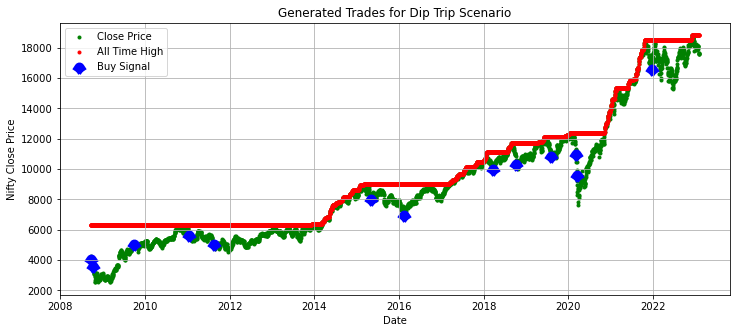

In [ ]:
plt.figure(figsize=(12,5), facecolor=(1, 1, 1))
plt.scatter(x=pd.to_datetime(data_dip['Date']).values, y=data_dip['Close'], 
            color='g', marker='.', linewidth=1, label='Close Price')
plt.scatter(x=pd.to_datetime(data_dip['Date']).values, y=data_dip['all-time-next-high'], 
            color='r', marker='.', linewidth=1, label='All Time High')
plt.scatter(pd.to_datetime(result_dip['Date']).values, result_dip['Close'], 
            color='b', marker=6, linewidth=10, label='Buy Signal')
plt.legend()
plt.ylabel('Nifty Close Price')
plt.xlabel('Date')
plt.title('Generated Trades for Dip Trip Scenario')
plt.grid()
plt.savefig('101_diptrip.png', 
            bbox_inches='tight', padding=1, Orientation='Landscape', dpi=200)

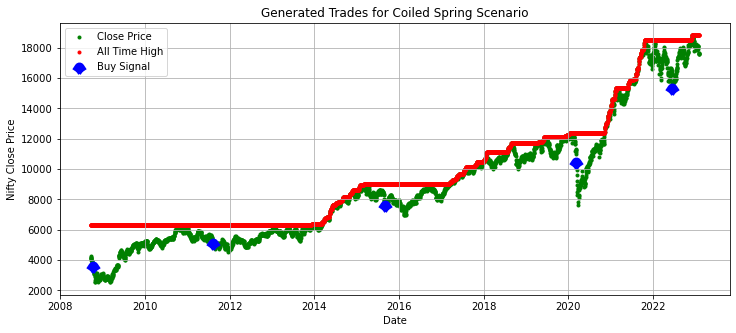

In [ ]:
plt.figure(figsize=(12,5), facecolor=(1, 1, 1))
plt.scatter(x=pd.to_datetime(data_dip['Date']).values, y=data_dip['Close'], 
            color='g', marker='.', linewidth=1, label='Close Price')
plt.scatter(x=pd.to_datetime(data_dip['Date']).values, y=data_dip['all-time-next-high'], 
            color='r', marker='.', linewidth=1, label='All Time High')
plt.scatter(pd.to_datetime(result_coiled_spring['Date']).values, result_coiled_spring['Close'], 
            color='b', marker=6, linewidth=10, label='Buy Signal')
plt.legend()
plt.ylabel('Nifty Close Price')
plt.xlabel('Date')
plt.title('Generated Trades for Coiled Spring Scenario')
plt.grid()
plt.savefig('102_coiledspring.png', 
            bbox_inches='tight', padding=1, Orientation='Landscape', dpi=200)

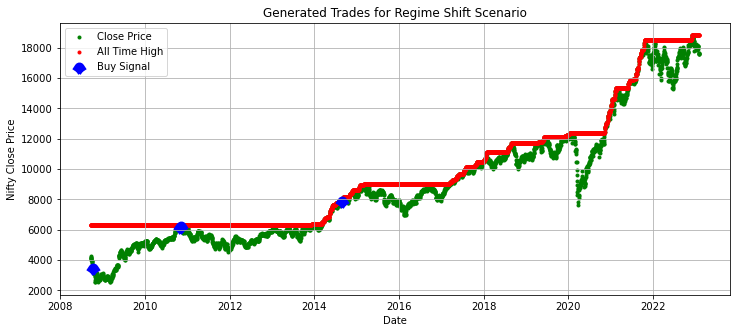

In [ ]:
plt.figure(figsize=(12,5), facecolor=(1, 1, 1))
plt.scatter(x=pd.to_datetime(data_dip['Date']).values, y=data_dip['Close'], 
            color='g', marker='.', linewidth=1, label='Close Price')
plt.scatter(x=pd.to_datetime(data_dip['Date']).values, y=data_dip['all-time-next-high'], 
            color='r', marker='.', linewidth=1, label='All Time High')
plt.scatter(pd.to_datetime(result_regime['Date']).values, result_regime['Close'], 
            color='b', marker=6, linewidth=10, label='Buy Signal')
plt.legend()
plt.ylabel('Nifty Close Price')
plt.xlabel('Date')
plt.title('Generated Trades for Regime Shift Scenario')
plt.grid()
plt.savefig('103_regimeshift.png', 
            bbox_inches='tight', padding=1, Orientation='Landscape', dpi=200)

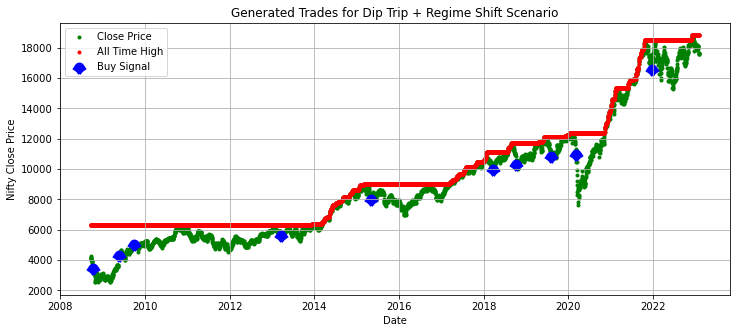

In [ ]:
plt.figure(figsize=(12,5), facecolor=(1, 1, 1))
plt.scatter(x=pd.to_datetime(data_dip['Date']).values, y=data_dip['Close'], 
            color='g', marker='.', linewidth=1, label='Close Price')
plt.scatter(x=pd.to_datetime(data_dip['Date']).values, y=data_dip['all-time-next-high'], 
            color='r', marker='.', linewidth=1, label='All Time High')
plt.scatter(pd.to_datetime(result_dip_regime['Date']).values, result_dip_regime['Close'], 
            color='b', marker=6, linewidth=10, label='Buy Signal')
plt.legend()
plt.ylabel('Nifty Close Price')
plt.xlabel('Date')
plt.title('Generated Trades for Dip Trip + Regime Shift Scenario')
plt.grid()
plt.savefig('104_diptrip_regimeshift.png', 
            bbox_inches='tight', padding=1, Orientation='Landscape', dpi=200)

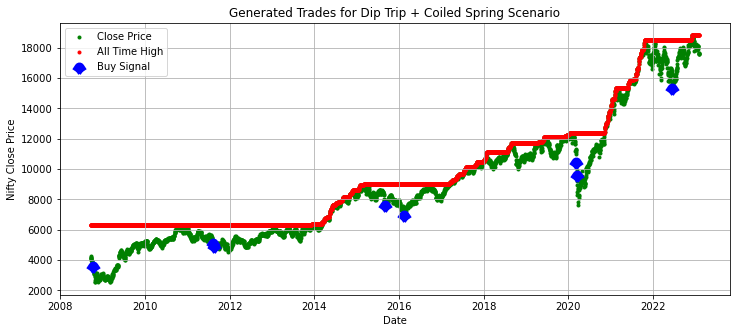

In [ ]:
plt.figure(figsize=(12,5), facecolor=(1, 1, 1))
plt.scatter(x=pd.to_datetime(data_dip['Date']).values, y=data_dip['Close'], 
            color='g', marker='.', linewidth=1, label='Close Price')
plt.scatter(x=pd.to_datetime(data_dip['Date']).values, y=data_dip['all-time-next-high'], 
            color='r', marker='.', linewidth=1, label='All Time High')
plt.scatter(pd.to_datetime(result_dip_coiled_spring['Date']).values, result_dip_coiled_spring['Close'], 
            color='b', marker=6, linewidth=10, label='Buy Signal')
plt.legend()
plt.ylabel('Nifty Close Price')
plt.xlabel('Date')
plt.title('Generated Trades for Dip Trip + Coiled Spring Scenario')
plt.grid()
plt.savefig('105_diptrip_coiledspring.png', 
            bbox_inches='tight', padding=1, Orientation='Landscape', dpi=200)

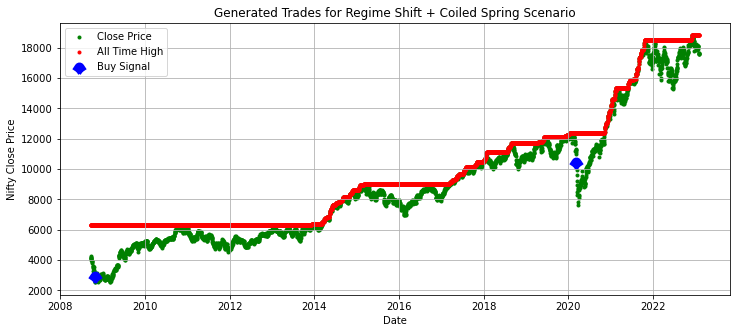

In [ ]:
plt.figure(figsize=(12,5), facecolor=(1, 1, 1))
plt.scatter(x=pd.to_datetime(data_dip['Date']).values, y=data_dip['Close'], 
            color='g', marker='.', linewidth=1, label='Close Price')
plt.scatter(x=pd.to_datetime(data_dip['Date']).values, y=data_dip['all-time-next-high'], 
            color='r', marker='.', linewidth=1, label='All Time High')
plt.scatter(pd.to_datetime(result_regime_coiled_spring['Date']).values, result_regime_coiled_spring['Close'], 
            color='b', marker=6, linewidth=10, label='Buy Signal')
plt.legend()
plt.ylabel('Nifty Close Price')
plt.xlabel('Date')
plt.title('Generated Trades for Regime Shift + Coiled Spring Scenario')
plt.grid()
plt.savefig('106_regimeshift_coiledspring.png', 
            bbox_inches='tight', padding=1, Orientation='Landscape', dpi=200)

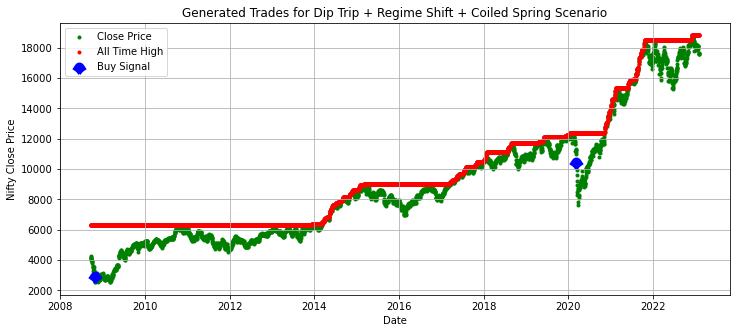

In [ ]:
plt.figure(figsize=(12,5), facecolor=(1, 1, 1))
plt.scatter(x=pd.to_datetime(data_dip['Date']).values, y=data_dip['Close'], 
            color='g', marker='.', linewidth=1, label='Close Price')
plt.scatter(x=pd.to_datetime(data_dip['Date']).values, y=data_dip['all-time-next-high'], 
            color='r', marker='.', linewidth=1, label='All Time High')
plt.scatter(pd.to_datetime(result_dip_regime_coiled_spring['Date']).values, result_dip_regime_coiled_spring['Close'], 
            color='b', marker=6, linewidth=10, label='Buy Signal')
plt.legend()
plt.ylabel('Nifty Close Price')
plt.xlabel('Date')
plt.title('Generated Trades for Dip Trip + Regime Shift + Coiled Spring Scenario')
plt.grid()
plt.savefig('107_diptrip_regimeshift_coiledspring.png', 
            bbox_inches='tight', padding=1, Orientation='Landscape', dpi=200)

In [ ]:
# Export results for each scenario
result_dip.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1).to_csv('10001_result_dip.csv')

result_coiled_spring.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1).to_csv('10002_result_coiled_spring.csv')

result_regime.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1).to_csv('10003_result_regime.csv')

result_dip_regime.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1).to_csv('10004_result_dip_regime.csv')

result_dip_coiled_spring.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], 
                              axis=1).to_csv('10005_result_dip_coiled_spring.csv')

result_regime_coiled_spring.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], 
                                 axis=1).to_csv('10006_result_regime_coiled_spring.csv')

result_dip_regime_coiled_spring.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], 
                                     axis=1).to_csv('10007_result_dip_regime_coiled_spring.csv')